# Imports

In [2]:
import tensorflow as tf
import tensorflow_io as tfio

In [3]:
from IPython.display import Audio

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact

In [5]:
%load_ext autoreload 
%autoreload 2
%reload_ext autoreload

In [12]:
from birds.data.spectrogram import generate_tensor, generate_spectrogram
from birds.data.spectrogram import generate_mel_spectrogram, generate_db_scale_mel_spectrogram

# Tensorflow Dataset

## Try with images

In [7]:
def read_image(file_name, label):
    image = tf.io.read_file(directory_0 + file_name)
    image = tf.io.decode_image(image, channels=1, dtype=tf.float32)
    return image, label

In [8]:
directory_0 = '/Users/Charlotte/Desktop/Photos/'

df_0 = pd.read_csv(directory_0 + 'train.csv')

file_paths_0 = df_0['file_name'].values
labels_0 = df_0['label'].values

ds_train_0 = tf.data.Dataset.from_tensor_slices((file_paths_0, labels_0))
ds_train_0

<TensorSliceDataset shapes: ((), ()), types: (tf.string, tf.int64)>

In [9]:
ds_train_0 = ds_train_0.map(read_image).batch(2)
ds_train_0

<BatchDataset shapes: (<unknown>, (None,)), types: (tf.float32, tf.int64)>

## Try with audio files // test in the notebook

In [10]:
def generate_mel_spectrogram_test(file_path, label):
    audio = tfio.audio.AudioIOTensor(file_path, dtype='float32')
    tensor = audio.to_tensor()
    input_rate = tf.cast(audio.rate, tf.int64)
    resample_tensor = tfio.audio.resample(tensor, input_rate, 16_000, name=None)
    split_tensor = resample_tensor[:160_000]
    harmonized_tensor = tf.reduce_mean(split_tensor, 1)
    spectrogram = tfio.audio.spectrogram(harmonized_tensor, nfft=2048, window=256, stride=256)
    mel_spectrogram = tfio.audio.melscale(spectrogram, rate=16_000, mels=128, fmin=0, fmax=8000)
    return tf.transpose(mel_spectrogram, perm=[1, 0]), label

In [11]:


ds_train = tf.data.Dataset.from_tensor_slices((file_paths, labels))
print(ds_train)

ds_train = ds_train.map(generate_mel_spectrogram_test).batch(1)
print(ds_train)

<TensorSliceDataset shapes: ((), ()), types: (tf.string, tf.int64)>
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
<BatchDataset shapes: ((None, None, None), (None,)), types: (tf.float32, tf.int64)>


## Try with audio files // import functions from `spectrogram.py`

In [13]:
directory = '../raw_data/data_30s/train/'

df = pd.read_csv(directory + 'y_train.csv')
df.head()

Path  Target
0  Sonus-naturalis-447407_tens.ogg       0
1  Sonus-naturalis-387437_tens.ogg       0
2  Sonus-naturalis-383228_tens.ogg       0
3  Sonus-naturalis-358240_tens.ogg       0
4  Sonus-naturalis-397031_tens.ogg       0

In [17]:
file_paths = directory + df['Path'].values
labels = df['Target'].values

ds_train = tf.data.Dataset.from_tensor_slices((file_paths, labels))
print(ds_train)

<TensorSliceDataset shapes: ((), ()), types: (tf.string, tf.int64)>


In [18]:
ds_train = ds_train.map(generate_mel_spectrogram).batch(1)
print(ds_train)

<BatchDataset shapes: ((None, None, None), (None,)), types: (tf.float32, tf.int64)>


In [20]:
spectrogram, label = next(iter(ds_train))

In [27]:
spectrogram.numpy().shape

(1, 128, 625)

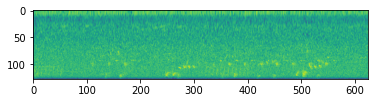

In [31]:
plt.imshow(tf.math.log(spectrogram.numpy()[0, :, :]));

# First model

In [49]:
from tensorflow.keras import models, layers

In [50]:
model = models.Sequential()

model.add(layers.InputLayer((128, 625)))
model.add(layers.Conv2D(16, (3,3), padding='same'))
model.add(layers.Flatten())
model.add(layers.Dense(10))

ValueError: Input 0 of layer conv2d_4 is incompatible with the layer: : expected min_ndim=4, found ndim=3. Full shape received: (None, 128, 625)